In [425]:
# Purpose of this Python script is to better understand the mechanics of the LSTM recurrent neural network approach.
# The application I have chosen is one that matches my background very well: economics and finance
# Objective is to predict the level of S&P 500 by using various economic indicators on a quarterly lag
# The reality is that predicting the S&P 500 is nearly impossible, which lends credit to the theory of a random walk

# The code was largely leveraged following the steps outlined in the following article:
# https://towardsdatascience.com/how-to-convert-pandas-dataframe-to-keras-rnn-and-back-to-pandas-for-multivariate-regression-dcc34c991df9

In [426]:
import numpy as np
import datetime
import pandas as pd
import matplotlib as plt
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM




In [427]:
# Collecting economic data from FRED and SPY price data from Yahoo Finance

In [428]:
start = datetime.datetime(1975, 1, 1)

end = datetime.datetime(2020, 10, 1)

data = web.DataReader(['T10Y2Y', 'HOUST', 'PPIACO', 'BAMLH0A0HYM2', 'TEDRATE'], 'fred', start, end)
data = data.dropna()


df = web.DataReader('SPY','yahoo', start, end).reset_index()
df.drop(['High', 'Low', 'Open', 'Volume', 'Adj Close'], axis = 1, inplace = True)

df2 = pd.merge(data, df, left_on = 'DATE', right_on = 'Date')

for column in df2[['T10Y2Y', 'HOUST', 'PPIACO', 'BAMLH0A0HYM2', 'TEDRATE']]:
   # Select column contents by column name using [] operator
   df2[column] = df2[column].shift(periods = 1)
   

df2 = df2.dropna()

print(df2)







     T10Y2Y   HOUST  PPIACO  BAMLH0A0HYM2  TEDRATE       Date       Close
1      0.48  1492.0   127.0          2.90     0.63 1997-05-01   80.000000
2      0.42  1442.0   127.4          2.91     0.71 1997-07-01   89.343750
3      0.43  1437.0   126.9          2.70     0.77 1997-08-01   94.937500
4      0.31  1390.0   127.2          2.57     0.55 1997-10-01   95.625000
5      0.29  1520.0   127.8          2.63     0.80 1997-12-01   98.093750
..      ...     ...     ...           ...      ...        ...         ...
169    0.09  1340.0   198.6          4.08     0.31 2019-11-01  306.140015
170    0.17  1371.0   199.0          4.09     0.40 2020-04-01  246.149994
171    0.39   934.0   185.5          9.11     1.35 2020-05-01  282.790009
172    0.44  1038.0   188.6          7.70     0.42 2020-06-01  305.549988
173    0.52  1265.0   191.1          6.43     0.20 2020-07-01  310.519989

[173 rows x 7 columns]


In [429]:
# Dropping the output column

In [430]:
y_col = 'Close' # define y variable, i.e., what we want to predict
print(df2.shape) # print the number of rows anc columns
df2.head()
df2.drop(['Date'], axis = 1, inplace = True)

print(df2.shape)


(173, 7)
(173, 6)


In [431]:
# Defining the training and test data

In [432]:
test_size = int(len(df2) * 0.2) # the test data will be 20% (0.2) of the entire data
train = df2.iloc[:-test_size,:].copy() 
# the copy() here is important, it will prevent us from getting: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame. Try using .loc[row_index,col_indexer] = value instead
test = df2.iloc[-test_size:,:].copy()
print(train.shape, test.shape)

(139, 6) (34, 6)


In [433]:
# Separating the X and Y training data

In [434]:
#separate X and y only for the train data (for now)
X_train = train.drop(y_col,axis = 1).copy()
y_train = train[[y_col]].copy() # the double brakets here are to keep the y in a dataframe format, otherwise it will be pandas Series
print(X_train.shape, y_train.shape)

(139, 5) (139, 1)


In [435]:
# Scaling the X and Y training data and converting into numpy arrays for keras

In [436]:
Xscaler = MinMaxScaler(feature_range = (0, 1)) # scale so that all the X data will range from 0 to 1
Xscaler.fit_transform(X_train)
scaled_X_train = Xscaler.transform(X_train)
print(X_train.shape)
Yscaler = MinMaxScaler(feature_range = (0, 1))
Yscaler.fit(y_train)
scaled_y_train = Yscaler.transform(y_train)
print(scaled_y_train.shape)
scaled_y_train = scaled_y_train.reshape(-1) # remove the second dimention from y so the shape changes from (n,1) to (n,)
print(scaled_y_train.shape)

scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)

(139, 5)
(139, 1)
(139,)


In [437]:
# Producing batches for training/validatio

In [438]:
n_input = 15 #how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features = X_train.shape[1] # how many predictors/Xs/features we have to predict y
b_size = 5 # Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length = n_input, batch_size = b_size)

print(generator[0][0].shape)

(5, 15, 5)


In [439]:
# Defining the LSTM RNN model

In [440]:
model = Sequential()
model.add(LSTM(250, activation = 'relu', input_shape = (n_input, n_features)))
model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse' )
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 250)               256000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 251       
Total params: 256,251
Trainable params: 256,251
Non-trainable params: 0
_________________________________________________________________


In [441]:
model.fit_generator(generator,epochs = 40)

Epoch 1/40
25/25 [==============================] - 1s 36ms/step - loss: 0.0772
Epoch 2/40
25/25 [==============================] - 0s 11ms/step - loss: 0.0425
Epoch 3/40
25/25 [==============================] - 0s 9ms/step - loss: 0.0341
Epoch 4/40
25/25 [==============================] - 0s 9ms/step - loss: 0.0233
Epoch 5/40
25/25 [==============================] - 0s 9ms/step - loss: 0.0201
Epoch 6/40
25/25 [==============================] - 0s 9ms/step - loss: 0.0235
Epoch 7/40
25/25 [==============================] - 0s 9ms/step - loss: 0.0267
Epoch 8/40
25/25 [==============================] - 0s 10ms/step - loss: 0.0174
Epoch 9/40
25/25 [==============================] - 0s 10ms/step - loss: 0.0231
Epoch 10/40
25/25 [==============================] - 0s 9ms/step - loss: 0.0204
Epoch 11/40
25/25 [==============================] - 0s 9ms/step - loss: 0.0110
Epoch 12/40
25/25 [==============================] - 0s 10ms/step - loss: 0.0084
Epoch 13/40
25/25 [=========================

(5, 15, 5)
        y_true      y_pred
0   281.579987  180.500122
1   267.700012  183.907883
2   264.980011  187.820084
3   273.600006  191.167511
4   280.859985  193.686295
5   291.730011  195.553940
6   273.510010  198.309372
7   270.059998  201.277557
8   280.420013  202.992218
9   285.829987  202.794571
10  291.809998  203.942291
11  295.660004  205.091019
12  294.839996  206.132019
13  293.239990  206.537125
14  306.140015  207.512161
15  246.149994  207.436279
16  282.790009  207.156174
17  305.549988  192.695206
18  310.519989  186.793945


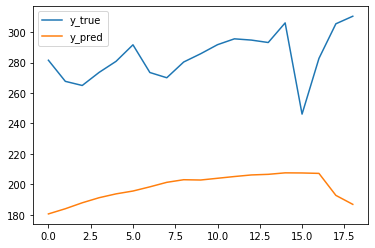

In [442]:
X_test = test.drop(y_col,axis = 1).copy()
scaled_X_test = Xscaler.transform(X_test)
test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length = n_input, batch_size = b_size)
print(test_generator[0][0].shape)

y_pred_scaled = model.predict(test_generator)
y_pred = Yscaler.inverse_transform(y_pred_scaled)
results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
print(results)
results.plot();